In [3]:
# globally useful imports of standard libraries needed in this notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
from datetime import datetime

# specific libraries or classes needed for the work in this notebook
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2, SelectFpr, f_regression, mutual_info_classif
#from sklearn.pipeline import Pipeline
# need to use Pipeline from imblearn to add in a downsample or upsample
# to cross validation training
from imblearn.pipeline import Pipeline

# import project specific modules used in this notebook
import sys
sys.path.append('../src')
import mindwandering.data
import mindwandering.features
import mindwandering.evaluate
from mindwandering.data import FeatureScalerTransformer
from mindwandering.data import WinsorizationOutlierTransformer
from mindwandering.data import VIFThresholdTransformer
from mindwandering.data import FeatureSelectionTransformer
from mindwandering.data import ClassImbalanceTransformer
from mindwandering.data import GridSearchProgressHack

In [4]:
# Load Data and Features
df_features = mindwandering.data.get_df_features()
mind_wandered_label = mindwandering.data.get_mind_wandered_label()
participant_ids = mindwandering.data.get_participant_ids()
# vif thresholds to apply to data and labels before grid search pipeline
vif_thresholds = [0, 5]

# we want to actually select a certain percentage of features of whatever remains
# after vif thresholding.  So we will calculate these in the loop based on the number
# of features in data, and add to the parameters dictionary before the grid search
features__k_ratios = np.array([0.25, 0.5, 0.75, 1.0])

# Empty dataframe to gather grid search results into 1 place
best_estimator = None
best_score = 0.0
best_params = {}
best_index = 0
df_result = None

# search over vif threshold meta parameters, create separate df from vif_threshold
# for otherwise identical grid searches
for vif_threshold in vif_thresholds:
    # display progress
    print('')
    print('=' * 50)
    print('Starting vif meta-parameter condition: vif_threshold: ', vif_threshold)
    
    # pipeline to apply vif threshold selection
    vif_pipeline = Pipeline(
      [
        ('vif',      VIFThresholdTransformer(score_threshold=vif_threshold)),
      ]
    )
 
    df_vif_features = vif_pipeline.transform(df_features)
    num_trials, num_features = df_vif_features.shape
    print('   Number of trials: ', num_trials, ' Number of Features: ', num_features)
    
    parameters = {
        'scaling__type_of_scaling': ['standard'],
        'outlier__outlier_threshold': [0.0, 2.0, 3.0],
        'features__score_func': [f_classif, f_regression],
        'balance__balancer_type': ['none', 'random-undersampler', 'smote'],
        'model__n_neighbors': [3,5,11,19],
        'model__weights': ['uniform','distance'],
        'model__metric': ['euclidean','manhattan'],
    }

    # set feature selection k correctly
    features__k = features__k_ratios * num_features
    features__k = features__k.astype(int) 
    parameters['features__k'] = features__k.tolist()

    # Estimator Pipeline
    pipeline = Pipeline(
      [
        ('progress', GridSearchProgressHack(verbose=False)),
        ('scaling',  FeatureScalerTransformer()),
        ('outlier',  WinsorizationOutlierTransformer()),
        ('features', SelectKBest()),
        ('balance',  ClassImbalanceTransformer()),
        ('model',    KNeighborsClassifier()),
      ]
    )
    
    # Cross Validation Splitter
    cv_group_splitter = GroupKFold(n_splits=5)
    #cv_group_splitter = LeaveOneGroupOut()

    # perform the grid search for this vif selection
    # set up the search
    search = GridSearchCV(
        estimator = pipeline,
        param_grid = parameters,
        scoring = ['roc_auc', 'accuracy'],
        cv = cv_group_splitter,
        refit = 'roc_auc',
        verbose = 1
        #n_jobs=-1 #to use all cpus
    )
    search.fit(df_vif_features, mind_wandered_label, groups=participant_ids)
    
    # append results onto the dataframe collecting the results.  Need to add
    # a feature column to this dataframe for the vif vit condition here
    df = pd.DataFrame(data=search.cv_results_)
    df['param__vif_score_threshold'] = vif_threshold
    
    if best_estimator is None:
        df_result = df
        best_estimator = search.best_estimator_
        best_score = search.best_score_
        best_params = search.best_params_
        best_index = search.best_index_
    else:
        df_result = df_result.append(df, ignore_index=True)
        if search.best_score_ > best_score:
            best_estimator = search.best_estimator_
            best_score = search.best_score_
            best_params = search.best_params_
            best_index = search.best_index_  # todo this is only the index of this search
            



Starting vif meta-parameter condition: vif_threshold:  0
   Number of trials:  4076  Number of Features:  62
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


001 002 003 004 005 006 007 008 009 010 011 012 013 014 015 016 017 018 019 020 021 022 023 024 025 026 027 028 029 030 031 032 033 034 035 036 037 038 039 040 041 042 043 044 045 046 047 048 049 050 051 052 053 054 055 056 057 058 059 060 061 062 063 064 065 066 067 068 069 070 071 072 073 074 075 076 077 078 079 080 081 082 083 084 085 086 087 088 089 090 091 092 093 094 095 096 097 098 099 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 

1840 1841 1842 1843 1844 1845 1846 1847 1848 1849 1850 1851 1852 1853 1854 1855 1856 1857 1858 1859 1860 1861 1862 1863 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 

3481 3482 3483 3484 3485 3486 3487 3488 3489 3490 3491 3492 3493 3494 3495 3496 3497 3498 3499 3500 3501 3502 3503 3504 3505 3506 3507 3508 3509 3510 3511 3512 3513 3514 3515 3516 3517 3518 3519 3520 3521 3522 3523 3524 3525 3526 3527 3528 3529 3530 3531 3532 3533 3534 3535 3536 3537 3538 3539 3540 3541 3542 3543 3544 3545 3546 3547 3548 3549 3550 3551 3552 3553 3554 3555 3556 3557 3558 3559 3560 3561 3562 3563 3564 3565 3566 3567 3568 3569 3570 3571 3572 3573 3574 3575 3576 3577 3578 3579 3580 3581 3582 3583 3584 3585 3586 3587 3588 3589 3590 3591 3592 3593 3594 3595 3596 3597 3598 3599 3600 3601 3602 3603 3604 3605 3606 3607 3608 3609 3610 3611 3612 3613 3614 3615 3616 3617 3618 3619 3620 3621 3622 3623 3624 3625 3626 3627 3628 3629 3630 3631 3632 3633 3634 3635 3636 3637 3638 3639 3640 3641 3642 3643 3644 3645 3646 3647 3648 3649 3650 3651 3652 3653 3654 3655 3656 3657 3658 3659 3660 3661 3662 3663 3664 3665 3666 3667 3668 3669 3670 3671 3672 3673 3674 3675 3676 3677 3678 3679 3680 

5120 5121 5122 5123 5124 5125 5126 5127 5128 5129 5130 5131 5132 5133 5134 5135 5136 5137 5138 5139 5140 5141 5142 5143 5144 5145 5146 5147 5148 5149 5150 5151 5152 5153 5154 5155 5156 5157 5158 5159 5160 5161 5162 5163 5164 5165 5166 5167 5168 5169 5170 5171 5172 5173 5174 5175 5176 5177 5178 5179 5180 5181 5182 5183 5184 5185 5186 5187 5188 5189 5190 5191 5192 5193 5194 5195 5196 5197 5198 5199 5200 5201 5202 5203 5204 5205 5206 5207 5208 5209 5210 5211 5212 5213 5214 5215 5216 5217 5218 5219 5220 5221 5222 5223 5224 5225 5226 5227 5228 5229 5230 5231 5232 5233 5234 5235 5236 5237 5238 5239 5240 5241 5242 5243 5244 5245 5246 5247 5248 5249 5250 5251 5252 5253 5254 5255 5256 5257 5258 5259 5260 5261 5262 5263 5264 5265 5266 5267 5268 5269 5270 5271 5272 5273 5274 5275 5276 5277 5278 5279 5280 5281 5282 5283 5284 5285 5286 5287 5288 5289 5290 5291 5292 5293 5294 5295 5296 5297 5298 5299 5300 5301 5302 5303 5304 5305 5306 5307 5308 5309 5310 5311 5312 5313 5314 5315 5316 5317 5318 5319 

5762 5763 5764 5765 5766 5767 5768 5769 5770 5771 5772 5773 5774 5775 5776 5777 5778 5779 5780 5781 5782 5783 5784 5785 5786 5787 5788 5789 5790 5791 5792 5793 5794 5795 5796 5797 5798 5799 5800 5801 5802 5803 5804 5805 5806 5807 5808 5809 5810 5811 5812 5813 5814 5815 5816 5817 5818 5819 5820 5821 5822 5823 5824 5825 5826 5827 5828 5829 5830 5831 5832 5833 5834 5835 5836 5837 5838 5839 5840 5841 5842 5843 5844 5845 5846 5847 5848 5849 5850 5851 5852 5853 5854 5855 5856 5857 5858 5859 5860 5861 5862 5863 5864 5865 5866 5867 5868 5869 5870 5871 5872 5873 5874 5875 5876 5877 5878 5879 5880 5881 5882 5883 5884 5885 5886 5887 5888 5889 5890 5891 5892 5893 5894 5895 5896 5897 5898 5899 5900 5901 5902 5903 5904 5905 5906 5907 5908 5909 5910 5911 5912 5913 5914 5915 5916 5917 5918 5919 5920 5921 5922 5923 5924 5925 5926 5927 5928 5929 5930 5931 5932 5933 5934 5935 5936 5937 5938 5939 5940 5941 5942 5943 5944 5945 5946 5947 5948 5949 5950 5951 5952 5953 5954 5955 5956 5957 5958 5959 5960 5961 

7402 7403 7404 7405 7406 7407 7408 7409 7410 7411 7412 7413 7414 7415 7416 7417 7418 7419 7420 7421 7422 7423 7424 7425 7426 7427 7428 7429 7430 7431 7432 7433 7434 7435 7436 7437 7438 7439 7440 7441 7442 7443 7444 7445 7446 7447 7448 7449 7450 7451 7452 7453 7454 7455 7456 7457 7458 7459 7460 7461 7462 7463 7464 7465 7466 7467 7468 7469 7470 7471 7472 7473 7474 7475 7476 7477 7478 7479 7480 7481 7482 7483 7484 7485 7486 7487 7488 7489 7490 7491 7492 7493 7494 7495 7496 7497 7498 7499 7500 7501 7502 7503 7504 7505 7506 7507 7508 7509 7510 7511 7512 7513 7514 7515 7516 7517 7518 7519 7520 7521 7522 7523 7524 7525 7526 7527 7528 7529 7530 7531 7532 7533 7534 7535 7536 7537 7538 7539 7540 7541 7542 7543 7544 7545 7546 7547 7548 7549 7550 7551 7552 7553 7554 7555 7556 7557 7558 7559 7560 7561 7562 7563 7564 7565 7566 7567 7568 7569 7570 7571 7572 7573 7574 7575 7576 7577 7578 7579 7580 7581 7582 7583 7584 7585 7586 7587 7588 7589 7590 7591 7592 7593 7594 7595 7596 7597 7598 7599 7600 7601 

9041 9042 9043 9044 9045 9046 9047 9048 9049 9050 9051 9052 9053 9054 9055 9056 9057 9058 9059 9060 9061 9062 9063 9064 9065 9066 9067 9068 9069 9070 9071 9072 9073 9074 9075 9076 9077 9078 9079 9080 9081 9082 9083 9084 9085 9086 9087 9088 9089 9090 9091 9092 9093 9094 9095 9096 9097 9098 9099 9100 9101 9102 9103 9104 9105 9106 9107 9108 9109 9110 9111 9112 9113 9114 9115 9116 9117 9118 9119 9120 9121 9122 9123 9124 9125 9126 9127 9128 9129 9130 9131 9132 9133 9134 9135 9136 9137 9138 9139 9140 9141 9142 9143 9144 9145 9146 9147 9148 9149 9150 9151 9152 9153 9154 9155 9156 9157 9158 9159 9160 9161 9162 9163 9164 9165 9166 9167 9168 9169 9170 9171 9172 9173 9174 9175 9176 9177 9178 9179 9180 9181 9182 9183 9184 9185 9186 9187 9188 9189 9190 9191 9192 9193 9194 9195 9196 9197 9198 9199 9200 9201 9202 9203 9204 9205 9206 9207 9208 9209 9210 9211 9212 9213 9214 9215 9216 9217 9218 9219 9220 9221 9222 9223 9224 9225 9226 9227 9228 9229 9230 9231 9232 9233 9234 9235 9236 9237 9238 9239 9240 

10568 10569 10570 10571 10572 10573 10574 10575 10576 10577 10578 10579 10580 10581 10582 10583 10584 10585 10586 10587 10588 10589 10590 10591 10592 10593 10594 10595 10596 10597 10598 10599 10600 10601 10602 10603 10604 10605 10606 10607 10608 10609 10610 10611 10612 10613 10614 10615 10616 10617 10618 10619 10620 10621 10622 10623 10624 10625 10626 10627 10628 10629 10630 10631 10632 10633 10634 10635 10636 10637 10638 10639 10640 10641 10642 10643 10644 10645 10646 10647 10648 10649 10650 10651 10652 10653 10654 10655 10656 10657 10658 10659 10660 10661 10662 10663 10664 10665 10666 10667 10668 10669 10670 10671 10672 10673 10674 10675 10676 10677 10678 10679 10680 10681 10682 10683 10684 10685 10686 10687 10688 10689 10690 10691 10692 10693 10694 10695 10696 10697 10698 10699 10700 10701 10702 10703 10704 10705 10706 10707 10708 10709 10710 10711 10712 10713 10714 10715 10716 10717 10718 10719 10720 10721 10722 10723 10724 10725 10726 10727 10728 10729 10730 10731 10732 10733 1073

In [5]:
# top 20 performers by the test_roc_auc score
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_result.sort_values('mean_test_roc_auc', axis=0, ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_balance__balancer_type,param_features__k,param_features__score_func,param_model__metric,param_model__n_neighbors,param_model__weights,param_outlier__outlier_threshold,param_scaling__type_of_scaling,params,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,param__vif_score_threshold
455,0.019790,0.000509,0.071792,0.002090,random-undersampler,15,<function f_regression at 0x7fb5c1f33940>,euclidean,19,distance,3,standard,{'balance__balancer_type': 'random-undersample...,0.652807,0.614083,0.640497,0.630905,0.628462,0.633351,0.012890,1,0.651961,0.624540,0.637255,0.638821,0.631902,0.636896,0.009038,397,0
404,0.020321,0.001541,0.084299,0.004546,random-undersampler,15,<function f_classif at 0x7fb5c1f33670>,euclidean,19,uniform,3,standard,{'balance__balancer_type': 'random-undersample...,0.643484,0.631564,0.602731,0.645270,0.630567,0.630723,0.015223,2,0.651961,0.622086,0.604167,0.644963,0.647853,0.634206,0.018256,411,0
407,0.019821,0.000733,0.068479,0.003117,random-undersampler,15,<function f_classif at 0x7fb5c1f33670>,euclidean,19,distance,3,standard,{'balance__balancer_type': 'random-undersample...,0.639874,0.609245,0.640542,0.642888,0.618914,0.630292,0.013623,3,0.650735,0.609816,0.644608,0.641278,0.619632,0.633214,0.015708,417,0
453,0.012342,0.000410,0.064847,0.003587,random-undersampler,15,<function f_regression at 0x7fb5c1f33940>,euclidean,19,distance,0,standard,{'balance__balancer_type': 'random-undersample...,0.645778,0.600373,0.629917,0.649567,0.625230,0.630173,0.017505,4,0.638480,0.607362,0.633578,0.640049,0.630675,0.630029,0.011821,452,0
452,0.019922,0.001539,0.086858,0.004017,random-undersampler,15,<function f_regression at 0x7fb5c1f33940>,euclidean,19,uniform,3,standard,{'balance__balancer_type': 'random-undersample...,0.650050,0.616588,0.624050,0.634416,0.623065,0.629634,0.011698,5,0.649510,0.630675,0.618873,0.625307,0.635583,0.631989,0.010376,435,0
405,0.013452,0.000656,0.062787,0.002970,random-undersampler,15,<function f_classif at 0x7fb5c1f33670>,euclidean,19,distance,0,standard,{'balance__balancer_type': 'random-undersample...,0.637472,0.621775,0.633378,0.640677,0.612658,0.629192,0.010453,6,0.650735,0.612270,0.626225,0.649877,0.631902,0.634202,0.014622,412,0
479,0.019725,0.000725,0.080348,0.002293,random-undersampler,15,<function f_regression at 0x7fb5c1f33940>,manhattan,19,distance,3,standard,{'balance__balancer_type': 'random-undersample...,0.638505,0.624765,0.618658,0.634787,0.624993,0.628341,0.007247,7,0.654412,0.617178,0.606618,0.630221,0.636810,0.629048,0.016425,458,0
403,0.020574,0.002413,0.085830,0.002288,random-undersampler,15,<function f_classif at 0x7fb5c1f33670>,euclidean,19,uniform,2,standard,{'balance__balancer_type': 'random-undersample...,0.636849,0.615089,0.618368,0.646149,0.624878,0.628267,0.011632,8,0.640931,0.620859,0.626225,0.646192,0.624540,0.631749,0.009940,436,0
450,0.012143,0.000475,0.080933,0.002872,random-undersampler,15,<function f_regression at 0x7fb5c1f33940>,euclidean,19,uniform,0,standard,{'balance__balancer_type': 'random-undersample...,0.652788,0.598168,0.635810,0.638927,0.608362,0.626811,0.020315,9,0.639706,0.608589,0.639706,0.651106,0.623313,0.632484,0.014874,426,0
402,0.013169,0.001320,0.078274,0.003045,random-undersampler,15,<function f_classif at 0x7fb5c1f33670>,euclidean,19,uniform,0,standard,{'balance__balancer_type': 'random-undersample...,0.644325,0.594705,0.625928,0.641376,0.626757,0.626618,0.017609,10,0.654412,0.619632,0.628676,0.637592,0.634356,0.634934,0.011490,406,0


In [6]:
# the average roc-auc and accuracy scores of just completed search.
# these are the averages of each model over the convolution folds.
#print(df_result['mean_test_roc_auc'])
#print(df_result['mean_test_accuracy'])
print(best_params)

{'balance__balancer_type': 'random-undersampler', 'features__k': 15, 'features__score_func': <function f_regression at 0x7fb5c1f33940>, 'model__metric': 'euclidean', 'model__n_neighbors': 19, 'model__weights': 'distance', 'outlier__outlier_threshold': 3.0, 'scaling__type_of_scaling': 'standard'}


Accuracy score:         0.8601570166830226
Recall (TPR) score:     1.0
Precision score:        0.661319073083779
AUC-ROC score:          0.9038137023287208

True positives:   1113
True negatives:   2393
False positives:  570
False negatives:  0
True Positive Rate (recall):  1.0
False Positive Rate:          0.1923725953425582
Specificity:                  0.8076274046574418

[[2393  570]
 [   0 1113]]


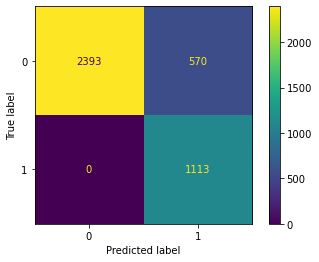

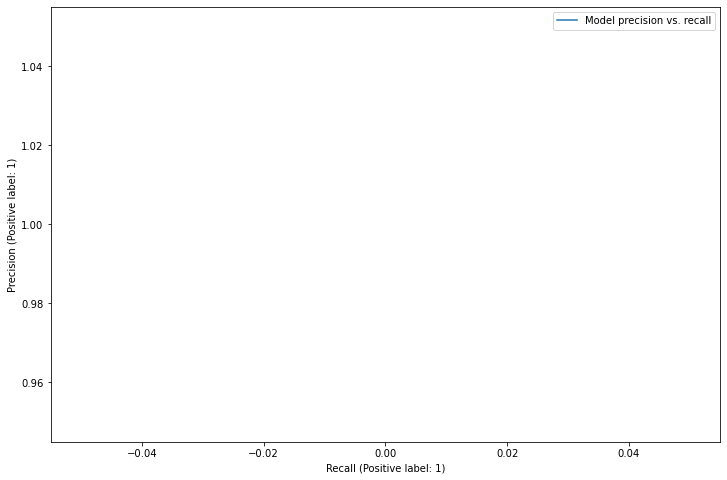

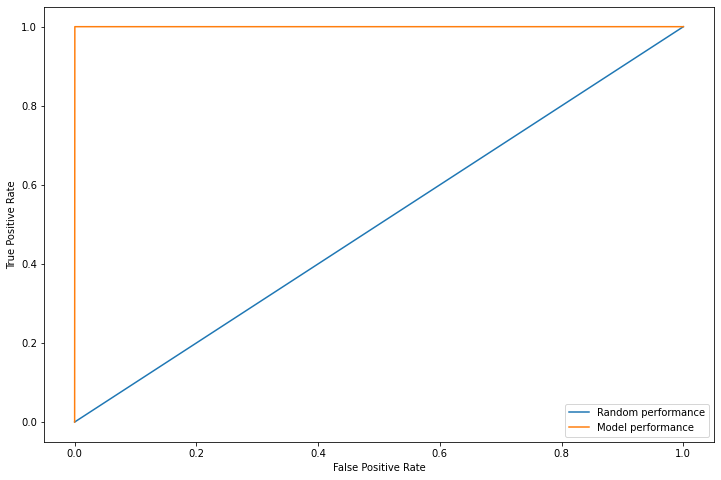

In [7]:
# display results for the best estimator we found
predictions = best_estimator.predict(df_features)
probabilities = best_estimator.predict_proba(df_features)[:,1]
mindwandering.evaluate.evaluate_model_results(mind_wandered_label, predictions, probabilities)

In [8]:
# save the results and preliminary figures in the following cells

# create base save file name for this file, use datetime to keep a unique file name
now = datetime.now()
date_time = now.strftime('%Y%m%d-%H%M')
result_file_basename = 'replication-02-kNN-' + date_time
print(result_file_basename)

replication-02-kNN-20210409-2201


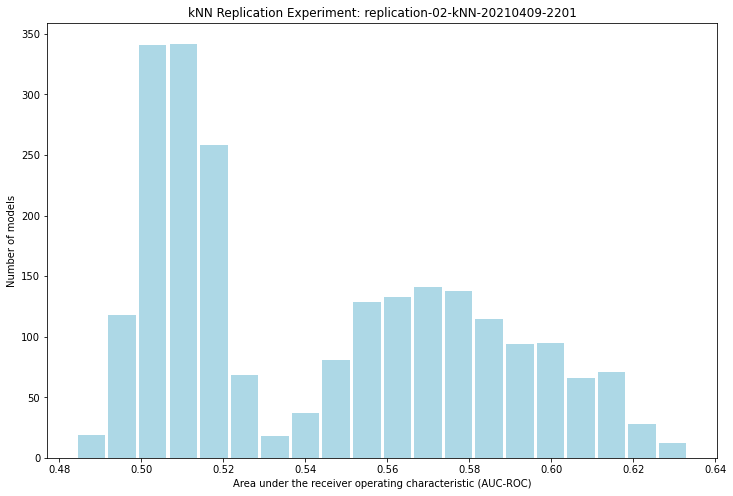

In [9]:
# A quick histogram of this search auc-roc scores.  Basically the figure 1 from the paper.
plt.figure(figsize=(12,8))

#bins = np.linspace(0.605, 0.612, 8)
plt.hist(df_result.mean_test_roc_auc, 
         bins=20,
         color='lightblue',
         rwidth=0.9);
plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.ylabel('Number of models');
plt.title('kNN Replication Experiment: ' + result_file_basename);

result_dir = '../figures'
result_file_name = result_file_basename + '.eps'
result_file_path = os.path.join(result_dir, result_file_name)
plt.savefig(result_file_path)

In [10]:
# save the search results dataframe to a file so can retrieve for later data analysis or
# to combine with other grid search results for summaries
result_dir = '../results'
result_file_name = result_file_basename + '.pkl'
result_file_path = os.path.join(result_dir, result_file_name)
df_result.to_pickle(result_file_path)